## Árboles de decisión
### Sesion 5

En esta sesión veremos:
 
1. Arboles de Regresión
2. Arboles de Clasificación

# Parte 1: Árboles de regresion

Datos de jugadores de Grandes Ligas de Béisbol de 1986-87:

- **Años** (eje x): cantidad de años jugando en las ligas mayores
- **Hits** (eje y): cantidad de visitas en el año anterior
- **Salario** (color): salario bajo es azul/verde, salario alto es rojo/amarillo

![Salary data](https://github.com/justmarkham/DAT8/raw/226791169b1cc6df8e8845c12e34e748d5ffaa85/notebooks/images/salary_color.png)

- Los datos anteriores son nuestros **datos de entrenamiento**.
- Queremos construir un modelo que prediga el salario de **futuros jugadores** basado en años y hits.
- Vamos a "segmentar" el espacio de características en regiones, y luego usaremos el **Salario promedio en cada región** como el Salario predicho para futuros jugadores.
- Intuitivamente, queremos **maximizar** la similitud (u homogeneidad) dentro de una región determinada, y **minimizar** la similitud entre diferentes regiones.

Reglas para segmentar:

- Solo usar **líneas rectas**, dibujando una a la vez.
- La línea debe ser **vertical u horizontal**.
- Tu línea **se detiene** cuando encuentra una línea existente.

![Salary regions](https://github.com/justmarkham/DAT8/raw/226791169b1cc6df8e8845c12e34e748d5ffaa85/notebooks/images/salary_regions.png)

- $ R_1 $: jugadores con **menos de 5 años** de experiencia, salario promedio de **\$166,000**
- $ R_2 $: jugadores con **5 o más años** de experiencia y **menos de 118 hits**, salario promedio de **\$403,000**
- $ R_3 $: jugadores con **5 o más años** de experiencia y **118 hits o más**, salario promedio de **\$846,000**

**Nota:** Años y hits son números enteros, pero la convención es usar el **punto medio** entre valores adyacentes para etiquetar una división.

Estas regiones se utilizan para hacer predicciones sobre **datos fuera de la muestra**. ¡Por lo tanto, solo hay tres predicciones posibles! (¿Es esto diferente de cómo una **regresión lineal** hace predicciones?)

A continuación se muestra el árbol de regresión equivalente:

![Salary tree](https://github.com/justmarkham/DAT8/raw/226791169b1cc6df8e8845c12e34e748d5ffaa85/notebooks/images/salary_tree.png)

La primera división es **Años <4.5**, por lo tanto, esa división va en la parte superior del árbol. Cuando una regla de división es **Verdadero**, sigue la rama izquierda. Cuando una regla de división es **Falsa**, sigue la rama derecha.

Para los jugadores en la **rama izquierda**, el Salario promedio es \$166,000, por lo tanto, lo etiqueta con ese valor. (El salario se ha dividido entre 1000 y se ha transformado logarítmicamente a 5.11.)

Para los jugadores en la **rama derecha**, hay una división adicional en **Hits <117.5**, que divide a los jugadores en dos regiones salariales más: **\$403,000** transformado a 6.00 y **\$846,000**, transformado a 6.74.

![Salary tree annotated](https://github.com/justmarkham/DAT8/raw/226791169b1cc6df8e8845c12e34e748d5ffaa85/notebooks/images/salary_tree_annotated.png)

**¿Qué le dice este árbol sobre los datos?**

- Años es el factor más importante para determinar el salario, con un menor número de años correspondiente a un salario más bajo.
- Para un jugador con menos años, Hits no es un factor importante para determinar el salario.
- Para un jugador con un mayor número de años, Hits es un factor importante que determina el salario, con un mayor número de Hits correspondiente a un salario más alto.

In [4]:
#Ejemplo
import pandas as pd
url = 'https://github.com/vanejaime/Curso_Python_CD/raw/master/datasets/vehicles_train.csv'
train = pd.read_csv(url)
train.head()

,price,year,miles,doors,vtype
0,22000,2012,13000,2,car
1,14000,2010,30000,2,car
2,13000,2010,73500,4,car
3,9500,2009,78000,4,car
4,9000,2007,47000,4,car


In [20]:
train['vtype'] = train.vtype.map({'car':0, 'truck':1})

In [21]:
feature_cols = ['year', 'miles', 'doors', 'vtype']
X = train[feature_cols]
y = train.price

In [22]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [23]:
# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model
import numpy as np
from sklearn.model_selection import cross_val_score
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

3107.1428571428573

## Que pasa si dejamos crecer un arbol?
- Izquierda: árbol de regresión para Salario **más profundo**
- Derecha: Comparación de los **errores de train, test y cross-validation** para árboles con diferentes profunidades

![Salary tree grown deep](https://github.com/justmarkham/DAT8/raw/226791169b1cc6df8e8845c12e34e748d5ffaa85/notebooks/images/salary_tree_deep.png)

## Afinar un arbol de regresion (tuning)

Intentemos reducir el RMSE ajustando el parámetro **max_depth**:

In [75]:
max_depth_range = range(1, 8)
RMSE_scores = []

for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

Text(0, 0.5, 'RMSE (lower is better)')

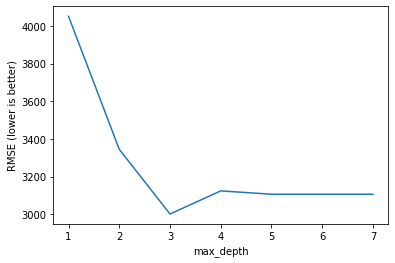

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [77]:
# max_depth=3 fue mejor, así que ajusta un árbol usando ese parámetro
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

In [78]:
# "Gini importance" de cada variable: la reducción total (normalizada) del error dada a esa variable
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,vtype,0.000000


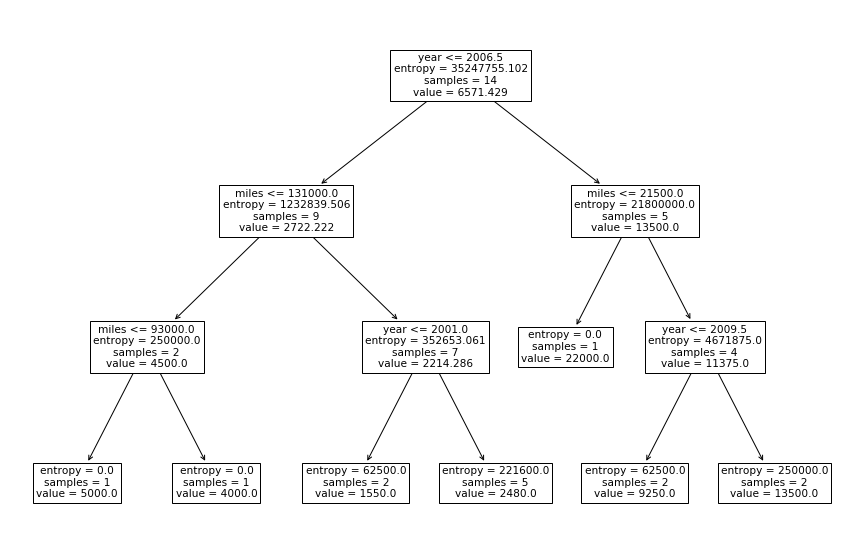

In [81]:
from sklearn import tree
fig, ax = plt.subplots(figsize=(15, 10))  # whatever size you want
tree.plot_tree(treereg.fit(X, y), ax=ax, feature_names=feature_cols)
plt.show()

Lectura de los nodos internos:

- **samples:** número de observaciones en ese nodo antes de dividir
- **entropy:** MSE calculado comparando los valores de respuesta reales en ese nodo con el valor de respuesta promedio en ese nodo
- **regla:** regla utilizada para dividir ese nodo (ir a la izquierda si es verdadero, ir a la derecha si es falso)

Leyendo las hojas:

- **samples:** número de observaciones en ese nodo
- **value:** valor medio de respuesta en ese nodo
- **entropy:** MSE calculado comparando los valores de respuesta reales en ese nodo con el "value"

In [82]:
url = 'https://github.com/vanejaime/Curso_Python_CD/raw/master/datasets/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


**Pregunta:** Usando el diagrama de árbol anterior, ¿qué predicciones hará el modelo para cada observación?

In [83]:
# use fitted model to make predictions on testing data
X_test = test[feature_cols]
y_test = test.price
y_pred = treereg.predict(X_test)
y_pred

array([ 4000.,  5000., 13500.])

In [84]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

1190.2380714238084

# Parte 2: Arbol de clasificación 

**Ejemplo:** Predecir si Barack Obama o Hillary Clinton ganarán las primarias demócratas en un condado en particular en 2008:

![Obama-Clinton decision tree](https://github.com/justmarkham/DAT8/raw/226791169b1cc6df8e8845c12e34e748d5ffaa85/notebooks/images/obama_clinton_tree.jpg)

**Preguntas:**

- ¿Cuáles son las observaciones? ¿Cuántas observaciones hay?
- ¿Cuáles son las varaibles?
- ¿Cuál es la característica más predictiva?
- ¿Por qué el árbol se divide en la tasa de graduación de la escuela secundaria dos veces seguidas?
- ¿Cuál es la predicción de clase para el siguiente condado: 15% de afroamericanos, 90% de tasa de graduación de escuela.


## Comparación de árboles de regresión y árboles de clasificación.

|regresion |clasificacion|
|---|---|
|predecir una respuesta continua |predecir una respuesta categórica|
|predecir usando la respuesta media de cada hoja |predecir usando la clase más común de cada hoja|
|las divisiones se eligen para minimizar MSE |las divisiones se eligen para minimizar el índice Gini|

## Criterios de división para árboles de clasificación.

Opciones comunes para los criterios de división:

- **tasa de error de clasificación:** fracción de observaciones de entrenamiento en una región que no pertenece a la clase más común
- **índice de Gini:** medida de la varianza total entre clases en una región

### Ejemplo de tasa de error de clasificación

Supongamos que estamos prediciendo si alguien compra un iPhone o un Android:

<img src="clas_rate1.jpg">

El algoritmo del árbol de decisión intentará **cada división posible en todas las características**, y elegirá la división que **reduce la tasa de error más.**

### Ejemplo del Indice de Gini

Calcule el índice de Gini antes de hacer una división:

$$1 - \left(\frac {iPhone} {Total}\right)^2 - \left(\frac {Android} {Total}\right)^2 = 1 - \left(\frac {10} {25}\right)^2 - \left(\frac {15} {25}\right)^2 = 0.48$$

- El **valor máximo** del índice de Gini es 0.5, y ocurre cuando las clases están perfectamente equilibradas en un nodo.
- El **valor mínimo** del índice de Gini es 0, y ocurre cuando solo hay una clase representada en un nodo.
- Se dice que un nodo con un índice de Gini más bajo es más "puro".

Evaluación de la división en **género** usando el índice de Gini:

$$\text{Males: } 1 - \left(\frac {2} {14}\right)^2 - \left(\frac {12} {14}\right)^2 = 0.24$$
$$\text{Females: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{Weighted Average: } 0.24 \left(\frac {14} {25}\right) + 0.40 \left(\frac {11} {25}\right) = 0.31$$

Evaluación de la división en **edad** usando el índice de Gini:

$$\text{30 or younger: } 1 - \left(\frac {4} {12}\right)^2 - \left(\frac {8} {12}\right)^2 = 0.44$$
$$\text{31 or older: } 1 - \left(\frac {6} {13}\right)^2 - \left(\frac {7} {13}\right)^2 = 0.50$$
$$\text{Weighted Average: } 0.44 \left(\frac {12} {25}\right) + 0.50 \left(\frac {13} {25}\right) = 0.47$$

Nuevamente, el algoritmo del árbol de decisión intentará **cada división posible**, y elegirá la división que **reduce el índice de Gini (y por lo tanto aumenta la "pureza de nodo")**

### Comparación de la tasa de error de clasificación y el índice de Gini

- Generalmente se prefiere el índice de Gini porque hará divisiones que **aumentarán la pureza del nodo**, incluso si esa división no cambia la tasa de error de clasificación.
- La pureza del nodo es importante porque estamos interesados en las **proporciones de clase** en cada región, ya que así es como calculamos la **probabilidad predicha** de cada clase.
- El criterio de división predeterminado de scikit-learn para los árboles de clasificación es el índice de Gini.

Nota: Hay otro criterio de división común llamado **entropía**. Es numéricamente similar al índice de Gini, pero es más lento de calcular, por lo tanto, no es tan popular como el índice de Gini.

In [86]:
# read in the data
url = 'https://github.com/vanejaime/Curso_Python_CD/raw/master/datasets/titanic.csv.zip'
titanic = pd.read_csv(url)

titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})
titanic.Age.fillna(titanic.Age.median(), inplace=True)

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S


In [91]:
# create a DataFrame of dummy variables for Embarked
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)
embarked_dummies.head()

,Embarked_Q,Embarked_S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [92]:
titanic = pd.concat([titanic, embarked_dummies], axis=1)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1


In [93]:
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

- **Survived:** 0=died, 1=survived (response variable)
- **Pclass:** 1=first class, 2=second class, 3=third class
    - What will happen if the tree splits on this feature?
- **Sex:** 0=female, 1=male
- **Age:** numeric value
- **Embarked:** C or Q or S

In [104]:
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=3,random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [105]:
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,Pclass,0.242664
1,Sex,0.655584
2,Age,0.064494
3,Embarked_Q,0.000000
4,Embarked_S,0.037258


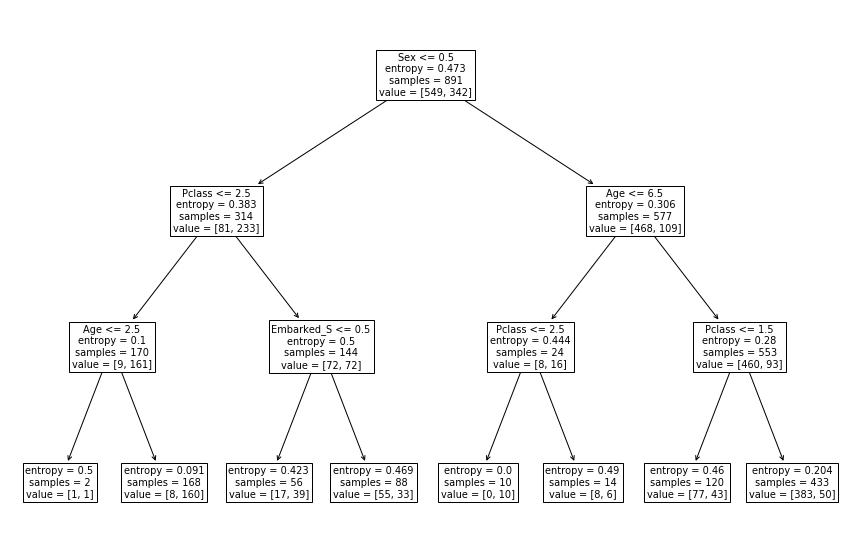

In [106]:
fig, ax = plt.subplots(figsize=(15, 10))  # whatever size you want
tree.plot_tree(treeclf.fit(X, y), ax=ax, feature_names=feature_cols)
plt.show()

# Parte 3: Comparación de árboles de decisión con otros modelos

**Ventajas de los árboles de decisión:**

- Se puede usar para regresión o clasificación
- Se puede mostrar gráficamente
- Altamente interpretable
- Se puede especificar como una serie de reglas y aproximarse más a la toma de decisiones humanas que otros modelos
- La predicción es rápida
- Tiende a ignorar características irrelevantes
- No paramétrico (superará a los modelos lineales si la relación entre las características y la respuesta es altamente no lineal)

![Trees versus linear models](https://raw.githubusercontent.com/justmarkham/DAT8/226791169b1cc6df8e8845c12e34e748d5ffaa85/notebooks/images/tree_vs_linear.png)

**Desventajas de los árboles de decisión:**

- El rendimiento (generalmente) no es competitivo con los mejores modelos de ML
- Puede sobreajustar fácilmente los datos de entrenamiento
- Pequeñas variaciones en los datos pueden dar como resultado un árbol completamente diferente (variación alta)
- La división binaria recursiva toma decisiones "localmente óptimas" que pueden no resultar en un árbol óptimo globalmente
- No tiende a funcionar bien si las clases están altamente desbalanceadas
- No tiende a funcionar bien con conjuntos de datos muy pequeños

Notebook construido a partir de notas de la clase Mineria de Datos - Maestría en Analytics -  Universidad de los Andes - Profesor Alejandro Correa